# Assess potential urban heatwave risks

This guide is separated into two different thematical sections. The first section describes how a heatwave risk map could be derived, while the second how to integrade land use information into the latter.

## Section A: Heatwave risk map

To produce the heatwave risk map, we will follow the workflow proposed by the EU-funded project [CLIMAAX](https://handbook.climaax.eu/notebooks/workflows/HEATWAVES/01_Urban_heatwaves/heatwave_intro.html), with some modifications in the libraries and code flow used.

To implement this workflow, we will need **Landsat 8 surface temperature raster maps** and **population density maps** disaggregated by sex and age.

### Population density maps

Raster maps representing age and sex structures can be obtained from [WorldPop Hub](https://hub.worldpop.org/geodata/listing?id=138). These maps have a **100 m spatial resolution** and are available for the years **2015 to 2030**. It is recommended to download a map corresponding to a year is which a **national population survey**, so that the validity of the raster data can be assessed.

A .zip file will be downloaded. When opended, it contains raster maps for **males (m), females (f)** and the **total population (t)**, each divided into the age groups: 00, 01, 05, 10, and so on, up to 90, in five years intervals.

### Section A - Step1: Load required libraries and functions

**Imports geospatial tools (rioxarray, geopandas) and defines helper functions for:**
* Extracting bounding boxes from geographic data
* Fetching Landsat 8 surface temperature images from the RSLab API
* Downloading and processing imagery

In [1]:
from pathlib import Path
from importlib import reload  # Not needed in Python 2
import rioxarray as rxr
import geopandas as gpd
from io import BytesIO
from shapely.ops import unary_union
import zipfile
from glob import glob
from datetime import datetime
import urllib.parse
import io
import json
import os
import requests
import pandas as pd
import folium

import logging

reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


In [2]:
BASE_URL = "https://landsatlst.appspot.com/Landsat8MODIS"
DOWNLOAD_BASE = "https://landsatlst.appspot.com/MODIS8Download"

def load_bbox_from_file(gdf):
    if gdf.empty:
        raise ValueError("GeoPackage empty or layer not found")
    
    # total_bounds returns (minx, miny, maxx, maxy)
    min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
    
    # Return bbox as polygon coordinates (in order)
    return [(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)]

def polygon_to_str(polygon):
    return ','.join([f'[{lon},{lat}]' for lon, lat in polygon])

def build_search_url(polygon, start_date, end_date):
    params = {'polygon': polygon_to_str(polygon), 'startDate': start_date, 'endDate': end_date}
    return f"{BASE_URL}?{urllib.parse.urlencode(params)}"

def fetch_images(search_url):
    r = requests.get(search_url)
    r.raise_for_status()
    data = r.json()
    return pd.read_json(io.StringIO(json.dumps(data))).T

def build_download_url(polygon, start_date, end_date, image_id):
    params = {'polygon': polygon_to_str(polygon), 'imageID': image_id, 'startDate': start_date, 'endDate': end_date}
    return f"{DOWNLOAD_BASE}?{urllib.parse.urlencode(params)}"

def download_from_response(resp_json, out_dir='.', date_acquired=None):
    if not isinstance(resp_json, dict):
        raise ValueError('Expected dict/JSON with a "download" key')
    else:
        download_url = resp_json.get('download')
    if not download_url:
        raise ValueError('No download URL in response')

    if date_acquired is not None:
        dt = datetime.strptime(date_acquired, '%Y/%m/%d_%H:%M:%S')
        fname = dt.strftime('%Y%m%d_%H%M%S') + '.zip'
    else:
        fname = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S') + '.zip'
    out_path = os.path.join(out_dir, fname)

    with requests.get(download_url, stream=True, allow_redirects=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

    return out_path

### Section A - Step2: Create necessary paths

Initially, create all the neccessary paths to read and save the derived data.


In [3]:
# Define main and subdirectories
main_path = Path("./")
lst_images = main_path / "lst_images"
study_area = main_path / "study_area"
output_folder = main_path / "output_folder"

# Create directories if they don't exist
for folder in [main_path, lst_images, study_area, output_folder]:
    if not folder.exists():
        folder.mkdir(parents=True, exist_ok=True)
        logger.info(f"Created folder: {folder}")

logger.info("All required directories are ready")

10:56:36 INFO: All required directories are ready


### Section A - Step3: Define area and date of interest


In [4]:
area_vector = 'Kavala.gpkg'
start_date = '2025/07/01'
end_date = '2025/07/30'

gdf_orig = gpd.read_file(f"{study_area}/{area_vector}")

# Fix geometry issues
gdf_orig["geometry"] = gdf_orig.buffer(0)

# Reproject to WGS84 (for folium)
gdf = gdf_orig.to_crs(epsg=4326)

# Dissolve multiple polygons if needed
if len(gdf) > 1:
    dissolved_geom = unary_union(gdf.geometry)
    gdf = gpd.GeoDataFrame(geometry=[dissolved_geom], crs=gdf.crs)

# Compute centroid in projected CRS
gdf_proj = gdf.to_crs(epsg=3857)
centroid = gdf_proj.geometry.centroid.to_crs(epsg=4326).iloc[0]
center = [centroid.y, centroid.x]  # type: ignore

# Create map
m = folium.Map(location=center, zoom_start=12)

# Add polygon layer
folium.GeoJson(
    gdf,
    name='Study Area',
    style_function=lambda feature: {
        'fillColor': 'red',
        'color': 'red',
        'weight': 2,
        'fillOpacity': 0.5
    }
).add_to(m)

m

### Section A - Step4: Obtain the Landsat 8 images

Landsat 8 raster maps can be obtained manually from the [RSLab](https://rslab.gr/Landsat_LST.html) platform.

For more information refer to the *Manuals & Updates* section available on [RSLab](https://rslab.gr/Landsat_LST.html).

An alternative method is by using the following code. The images will downloaded as different compressed .zip files, based on the area and the date defined above, named according to the acquisition date, *e.g., YYYYMMDD_HHMMSS.zip*.



In [5]:
polygon = load_bbox_from_file(gdf)
search_url = build_search_url(polygon, start_date, end_date)
images = fetch_images(search_url)

for _, image in images.iterrows():
    image_id = image.get('imageID') or image.get('IMAGE_ID')
    date_acq = image.get('DATE_ACQUIRED') or image.get('date_acquired')
    if not image_id:
        continue
    dl_url = build_download_url(polygon, start_date, end_date, image_id)
    dl_resp = requests.get(dl_url)
    dl_resp.raise_for_status()
    resp_json = dl_resp.json()
    saved = download_from_response(resp_json, out_dir=f'{lst_images}', date_acquired=date_acq)
    logger.info(f'Saved: {saved}')


10:56:45 INFO: Saved: lst_images\20250704_090342.zip
10:56:51 INFO: Saved: lst_images\20250704_090406.zip
10:56:57 INFO: Saved: lst_images\20250720_090347.zip
10:57:03 INFO: Saved: lst_images\20250720_090411.zip


### Section A - Step3: Load and clip the products to the study area boundaries

Before proceeding, make sure that the *LST images .zip* files has been retrieved to the *lst_images* directory you created earlier.

In [6]:
zip_files = sorted(lst_images.glob("*.zip"))

for zip_file in zip_files:
    logger.info(f"Processing ZIP: {zip_file.name}")

    with zipfile.ZipFile(zip_file, "r") as archive:
        tif_names = [n for n in archive.namelist()]

        if not tif_names:
            logger.warning(f"No TIFFs found in {zip_file.name}")
            continue

        for tif_name in tif_names:
            try:
                with archive.open(tif_name) as f:
                    raster = rxr.open_rasterio(BytesIO(f.read()), masked=True)
                logger.info(f"Loaded raster: {tif_name}")

                if raster.rio.crs is None: # type: ignore
                    logger.warning(f"No CRS for {tif_name}. Skipping.")
                    continue

                clipped = raster.rio.clip(gdf.geometry, gdf.crs, drop=True) # type: ignore
                out_path = output_folder / f"{Path(tif_name).stem}_clipped.tif"
                clipped.rio.to_raster(out_path)
                logger.info(f"Saved: {out_path}\n")

            except Exception as e:
                logger.error(f"Error processing {tif_name} in {zip_file.name}: {e}")


10:57:03 INFO: Processing ZIP: 20250704_090342.zip
10:57:03 INFO: Loaded raster: 20250704_090342.LST.tif
10:57:03 INFO: Saved: output_folder\20250704_090342.LST_clipped.tif

10:57:03 INFO: Processing ZIP: 20250704_090406.zip
10:57:03 INFO: Loaded raster: 20250704_090406.LST.tif
10:57:03 INFO: Saved: output_folder\20250704_090406.LST_clipped.tif

10:57:03 INFO: Processing ZIP: 20250720_090347.zip
10:57:03 INFO: Loaded raster: 20250720_090347.LST.tif
10:57:03 INFO: Saved: output_folder\20250720_090347.LST_clipped.tif

10:57:03 INFO: Processing ZIP: 20250720_090411.zip
10:57:03 INFO: Loaded raster: 20250720_090411.LST.tif
10:57:03 INFO: Saved: output_folder\20250720_090411.LST_clipped.tif



10:57:03 DEBUG: matplotlib data path: C:\Users\nikol\AppData\Roaming\Python\Python313\site-packages\matplotlib\mpl-data
10:57:03 DEBUG: CONFIGDIR=C:\Users\nikol\.matplotlib
10:57:03 DEBUG: interactive is False
10:57:03 DEBUG: platform is win32
10:57:03 DEBUG: CACHEDIR=C:\Users\nikol\.matplotlib
10:57:03 DEBUG: Using fontManager instance from C:\Users\nikol\.matplotlib\fontlist-v390.json



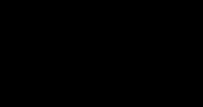

In [ ]:
# TODO : fix the code below to render the right way
import numpy as np
import matplotlib.pyplot as plt

tiff_list = glob(f"{output_folder}/*.tif")

raster = rxr.open_rasterio(tiff_list[0], masked=True)

if raster.rio.crs.to_string() != "EPSG:4326": # type: ignore
    raster = raster.rio.reproject("EPSG:4326") # type: ignore

band = raster.values[0]  # shape: (height, width)

band_min, band_max = band.min(), band.max()
band_norm = (band - band_min) / (band_max - band_min)

cmap = plt.get_cmap('jet')
colored = cmap(band_norm)  # Returns RGBA array (height, width, 4)
colored_rgb = (colored[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB

bounds = raster.rio.bounds()  # type: ignore # left, bottom, right, top

# ---------------------------
# 5. Create Folium map
# ---------------------------
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add raster overlay
folium.raster_layers.ImageOverlay(
    image=colored_rgb,
    bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    opacity=0.7,
    interactive=True,
    cross_origin=False,
    zindex=1
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m

### Section A - Step4: Load the clipped images, calculate the average temperature for each image, and plot the resulting time series.

In this step, a scatter plot will be created using the mean temperature values derived from each image.

This visualization helps to better understand the temperature conditions prevailing during the critical period, as well as any potential upward or downward trends over the years 2013–2025.

In [8]:
# This code extracts all dates from LST tif.files

# Create a list of file paths to your LST files using glob
L8list = glob(f"{output_folder}/*LST*.tif")
# Initialize an empty list to store the datetime objects
lst_dates = []
# Loop through each filename
for file in L8list:
    
    # Extract the filename without the directory path
    filename = Path(file).stem   
    
    # Extract the date and time part from the filename
    date_acq = datetime.strptime(filename, '%Y%m%d_%H%M%S.LST_clipped') # Extract date acquired
 
    # Append the datetime object to the lst_dates list
    lst_dates.append(date_acq)

lst_dates

[datetime.datetime(2025, 7, 4, 9, 3, 42),
 datetime.datetime(2025, 7, 4, 9, 4, 6),
 datetime.datetime(2025, 7, 20, 9, 3, 47),
 datetime.datetime(2025, 7, 20, 9, 4, 11)]